# Argentina programa 4.0 - Módulo 3: Aprendizaje Automático
---

# Semana 6: Redes Neuronales Artificiales

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Nuestra estrella aquí es el TensorFlow
import tensorflow as tf
from tensorflow import keras

In [11]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Redes Neuronales Artificiales

Vamos a explorar algunos usos básicos del paquete `keras` para construir y entrenar RNAs.

Hay diferentes formas en las que `keras` puede construir modelos de RNA. En particular, veremos las APIs Secuencial y Funcional. Para las redes feed-forward totalmente conectadas, la API Secuencial es probablemente la más directa.

## Redes neuronales como aproximadores

Construiremos un modelo para realizar la sencilla tarea de aproximar una función real 1-D.

### Con la API secuencial

In [12]:
# Instancia modelo
model1 = keras.models.Sequential()

# Usa el método add para añadir una capa de entrada (que también es una clase de keras)
model1.add(keras.layers.InputLayer(input_shape=(1,)))

# Añade dos capas ocultas totalmente conectadas (también llamadas densas)
# Se puede cambiar la función de activación
model1.add(keras.layers.Dense(5, activation='tanh'))
model1.add(keras.layers.Dense(4, activation='tanh'))

# Añade la capa de salida. Como se trata de un problema de regresión, elegimos la activación lineal
model1.add(keras.layers.Dense(1, activation='linear'))

Ahora usamos el método `summary` para ver una descripción de lo que acabamos de construir

In [13]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 10        
                                                                 
 dense_1 (Dense)             (None, 4)                 24        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 39 (156.00 Byte)
Trainable params: 39 (156.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


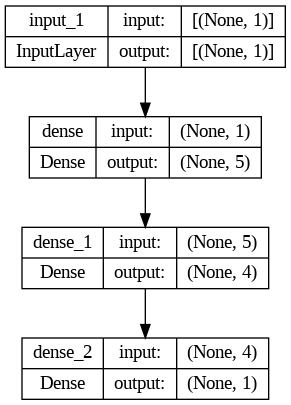

In [14]:
keras.utils.plot_model(model1, show_shapes=True)

### Compilación

Para que el modelo funcione, primero hay que compilarlo.

En este punto, hay que proporcionar dos datos cruciales
1. La función de error (también conocida como función de pérdida)
2. La función del optimizador.

In [15]:
model1.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=0.1))

### Preparación de los datos

Pongamos a prueba nuestro modelo con una función sencilla.

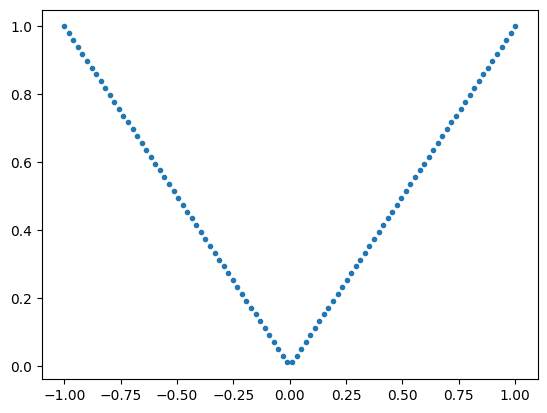

In [23]:
x = np.linspace(-1, 1, 100)

# Modulo
t = np.abs(x)

# Heavyside
# t = np.where(x > 0, 1, 0)

plt.plot(x, t, '.')

### Entrenamiento

Ahora estamos listos para ajustar el modelo.

En su forma más simple, el método `fit` toma el vector de entrada `x` (aquí 1-d) y la etiqueta `t` (aquí 1-d). También necesita un número de `epochs` o pasos a realizar en la dirección del gradiente.

**N.B.** De hecho, este es el número de veces que se evalúa el gradiente utilizando todos los puntos de datos, pero el Descenso Gradiente Estocástico realmente actualiza el vector de parámetros para cada lote (*batch*) de datos. Su tamaño también se puede proporcionar como un argumento para el método `fit`.

In [ ]:
model1.fit(x, t, batch_size=int(len(x)/4), epochs=250)

### Predicción

4/4 [==============================] - 0s 4ms/step


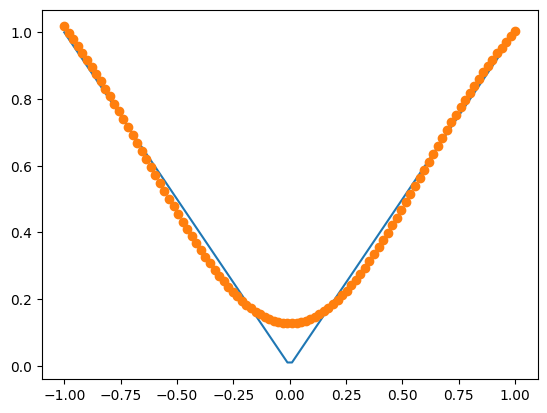

In [19]:
y = model1.predict(x)
plt.plot(x, t)
plt.plot(x, y, 'o')

### Bajo el capot

En esta red simple, podemos ver cómo funcionan las cosas. Obtengamos los pesos de cada capa.

In [20]:
w1, b1 = model1.layers[0].get_weights()
w2, b2 = model1.layers[1].get_weights()
w3, b3 = model1.layers[2].get_weights()

Los pesos son matrices cuyo tamaño está relacionado con el tamaño de la capa y el número de unidades que conecta.
El segundo argumento es un array con los pesos.

In [21]:
print(w2.shape, b2.shape)
print(w2, b2)

(5, 4) (4,)
[[ 0.8006681   0.5111804  -0.36339858 -0.6358165 ]
 [-0.3626498  -0.8824047   0.42161527  0.00314505]
 [ 0.6106536   0.71270376 -0.5379194  -0.4181775 ]
 [ 0.6084635   0.17535008  0.1803617   0.53891987]
 [ 0.7717276   0.41535532  0.644624    0.2660295 ]] [-0.4769745  -0.32849783 -0.00306795  0.09136601]


Con toda esta información, podemos calcular el resultado de la primera capa, para cada punto del conjunto de datos.

In [22]:
def acti(x):
    return np.tanh(x)

In [25]:
zz = []
for i in range(len(w1[0])):
  zz.append(acti(w1[0][i] * x + b1[i]))

    # xx = w1[0][i] * x + w0[i]
  # yy.append(np.where(xx > 0, xx, 0))

zz = np.array(zz).T
print(zz.shape)

(100, 5)


In [26]:
# Calcula salida de la segunda capa
yy = acti(np.dot(zz, w2) + b2)

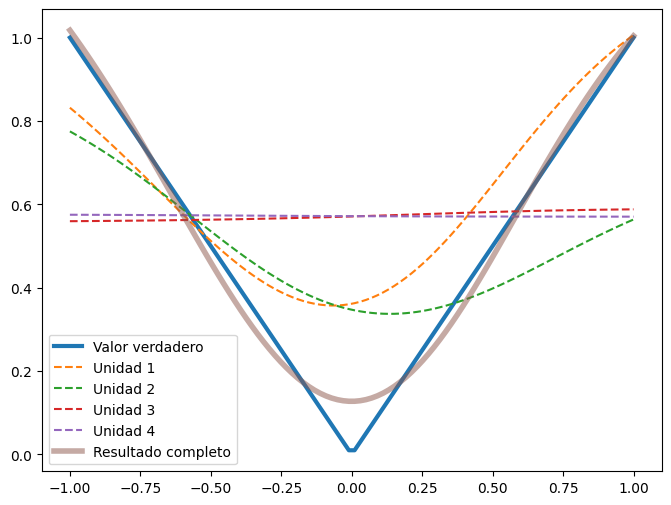

In [30]:
# El resultado final es la combinación de cada una de estas cuatro funciones, con un peso...
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(x, t, lw=3, label='Valor verdadero')
for i, yi in enumerate(yy.T):
  ax.plot(x, yi * w3[i] + b3, '--', label='Unidad {}'.format(i+1))

ax.plot(x, np.dot(yy, w3) + b3, label='Resultado completo', lw=4, alpha=0.5)
ax.legend(loc=0)

## MNIST a través de la lente de las RNAs

Vamos a reutilizar el conjunto de datos MNIST de números escritos a mano y a entrenar una red neuronal sencilla para clasificarlos.

El objetivo es entonces tratar de entender cómo funciona la red, por lo que vamos a elegir una arquitectura relativamente sencilla.

### Preparación de los datos

In [37]:
(X_train, t_train), (X_test, t_test) = keras.datasets.mnist.load_data()

Se acuerdan em tamaño deste dataset?

In [57]:
X_train.shape, X_test.shape, t_train.shape, t_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

Las etiquetas de `t_train` y `t_test` son números entre 0 y 9.

Lo primero que hacemos es convertir las etiquetas de clase a la codificación 1-de-K. Para ello utilizamos la función `keras.utils.to_categorical` (similar al  `OneHotEncoder` de `sklearn`).

In [38]:
t_train_ohe = keras.utils.to_categorical(t_train)
t_test_ohe = keras.utils.to_categorical(t_test)
print(t_train_ohe[:3], t_train[:3])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


A continuación, normalizamos las imágenes. Llevamos la escala de píxeles, originalmente entre 0 y 255 (o sea, 256 "niveles de gris"), al intervalo [0, 1).

In [39]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
0 255
0.0 1.0
0.0 1.0


No hay mucho más que hacer en cuanto a la preparación de los datos, porque `keras` ya divide el conjunto en conjuntos de entrenamiento y de prueba (que usaremos como validación).

Visualicemos simplemente a algunos individuos.

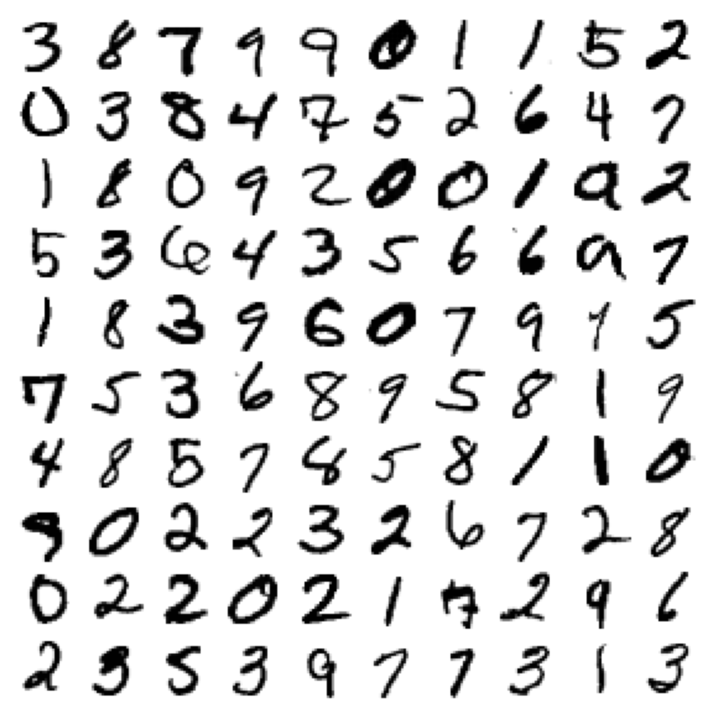

In [41]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
plot_digits(X_train[10000:10100], images_per_row=10)

### Definición del modelo.

¿Cómo empezamos a definir un modelo de este tipo? Tenemos que definir el número de capas, el número de unidades en cada capa, las funciones de activación, y varias cosas más.

Una posibilidad es pensar como funcionaria el reconocimiento de las imágines, separándolo en etapas y pensando que cada _capa de neuronas_ podría corresponder a una _etapa_ y cada _conjunto de reuronas_ podría hacer _una tarea de cada etapa_. Eso se manifiesta en la respuesta de cada neurona a in tipo de dato de entrada, o sea, a su _activación_ para cada dato.

Para ver después de la clase: un video de YouTube armando una red inspirada en ese tipo de razonamiento.

In [42]:
from IPython.display import YouTubeVideo
YouTubeVideo('aircAruvnKk?start=332', width=900, height=600)

Aqui vamos a implementar una red (completamente conectada) con 2 capas intermediarias, con 32 neruronas cada. El número de neuronas en las capas de entrada y de salida se define, respectivamente por los datos que queremos procesar (en este caso, imágenes de 28 x 28 pixeles) y por la salida de clasificación (1 valor para cada una de las 10 clases). Como es un problema de clasificación, usaremos la activación `softmax`.

In [43]:
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.Flatten(input_shape=(28,28)))

# Dos capas ocultas con 32 neuronas cada una
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))

# Capa de salida. Como es una clasificación multi-clase, usamo K (acá 10) unidades.
model.add(keras.layers.Dense(10, activation='softmax'))

### Compilación

Como estamos usando la codificación 1-de-K, necesitamos usar `categorical_crossentropy` como función de pérdida. Si usamos dígitos como etiquetas, la función adecuada es `sparse_categorical_crossentropy`.

También le decimos al modelo que controle la Precisión (pero podríamos proporcionar otras métricas aquí): `keras.metrics.Recall()`

In [44]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(class_id=5)])

***
**Juego**: ¿Pueden calcular el número de parámetros que tiene este modelo?

26506

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                25120     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenamiento

El entrenamiento puede ser complicado y/o costoso, incluso para una red pequeña como ésta.

Para acelerar el proceso, y comprobar que la red no está sobreajustada, añadiremos un paso adicional en el proceso de ajuste. Un _callback_ que puede detener el entrenamiento antes de tiempo si no se ve ninguna mejora en la pérdida de validación.

Esto se implementa en `EarlyStopping`. Volveremos sobre esto la semana que viene.

In [49]:
early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss',
                                      restore_best_weights=True)

En este caso, esperamos 15 épocas para ver una mejora. Si no se ve ninguna, el ajuste vuelve a los valores óptimos y se detiene el entrenamiento. Esto es _muy_ útil.

Sabemos que se ajusta al modelo, pero fíjate en los siguientes cambios:

1. La salida del método se almacena en una variable `ajuste` que contiene la evolución del proceso de traning.
2. Añadimos el argumento `validation_data` para definir qué conjunto de datos utilizar para la validación.
3. Incluimos un callback (podría haber una legión; ver `keras.callbacks` y [documentación](https://keras.io/api/callbacks/).

In [50]:
ajuste = model.fit(epochs=100, x=X_train, y=t_train_ohe, validation_data=(X_test, t_test_ohe),
                    callbacks=[early,])

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3368 - accuracy: 0.9039 - recall: 0.8072 - val_loss: 0.1885 - val_accuracy: 0.9442 - val_recall: 0.9013
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1776 - accuracy: 0.9500 - recall: 0.9229 - val_loss: 0.1622 - val_accuracy: 0.9522 - val_recall: 0.8913
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1429 - accuracy: 0.9583 - recall: 0.9382 - val_loss: 0.1467 - val_accuracy: 0.9572 - val_recall: 0.9417
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1231 - accuracy: 0.9640 - recall: 0.9441 - val_loss: 0.1295 - val_accuracy: 0.9622 - val_recall: 0.9518
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1103 - accuracy: 0.9680 - recall: 0.9539 - val_loss: 0.1269 - val_accuracy: 0.9633 - val_recall: 0.9439
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1017 -

Nos gustaría ver un gráfico de la evolución del ajuste. De esto se trata la variable `ajuste`.

In [51]:
ajuste.history

{'loss': [0.3367668688297272,
  0.17764602601528168,
  0.1428956687450409,
  0.12311679869890213,
  0.11028841882944107,
  0.10165596008300781,
  0.09409748017787933,
  0.08764223009347916,
  0.08272740989923477,
  0.07853007316589355,
  0.07369382679462433,
  0.07193905115127563,
  0.06830883771181107,
  0.06594409793615341,
  0.06304655224084854,
  0.06022188439965248,
  0.058146655559539795,
  0.05717604607343674,
  0.05584312975406647,
  0.052285484969615936,
  0.05064043402671814,
  0.04937644675374031,
  0.048595644533634186,
  0.045530736446380615],
 'accuracy': [0.9038500189781189,
  0.9499666690826416,
  0.9583166837692261,
  0.9639666676521301,
  0.9680166840553284,
  0.9698500037193298,
  0.972100019454956,
  0.9743499755859375,
  0.9761833548545837,
  0.9772999882698059,
  0.978683352470398,
  0.9797666668891907,
  0.9803666472434998,
  0.9811999797821045,
  0.9828500151634216,
  0.9827666878700256,
  0.9836999773979187,
  0.9836833477020264,
  0.9843666553497314,
  0.98540

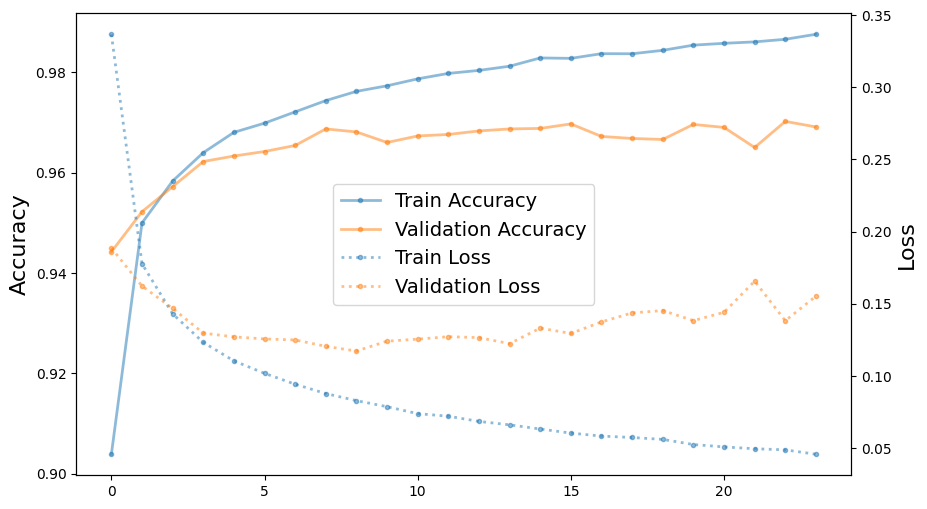

In [52]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

kw = {'marker': '.', 'lw': 2, 'alpha': 0.5}
l0, = ax.plot(ajuste.history['accuracy'], label='Train Accuracy', **kw)
l1, = ax.plot(ajuste.history['val_accuracy'], label='Validation Accuracy', **kw)

ax2 = ax.twinx()
ll0, = ax2.plot(ajuste.history['loss'], ls=':', color='C0', label='Train Loss', **kw)
ll1, = ax2.plot(ajuste.history['val_loss'], ls=':', color='C1', label='Validation Loss', **kw)

ax.set_ylabel('Accuracy', fontsize=16)
ax2.set_ylabel('Loss', fontsize=16)

ax.legend(handles=[l0, l1, ll0, ll1], loc='center', fontsize=14)
# plt.legend(loc=0)

### Análisis

Exploremos ahora un poco más los errores de la red. Para eso, trabajaremos con el conjunto de test (esto no es del todo correcto porque usamos el mismo conjunto para hacer la validación).

In [53]:
model.evaluate(X_test, t_test_ohe)

313/313 [==============================] - 1s 3ms/step - loss: 0.1171 - accuracy: 0.9681 - recall: 0.9563


[0.1171112060546875, 0.9681000113487244, 0.9562780261039734]

Veamos con más detalle los casos en los que la red cometió errores

In [54]:
model.predict(X_test).shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [58]:
# Calcular las predicciones y encontrar los casos con error
y_test = np.argmax(model.predict(X_test), axis=1)

ierror = (y_test - t_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de validación'.format(np.sum(ierror)))

313/313 [==============================] - 1s 2ms/step
Hay 319 errores en el conjunto de validación


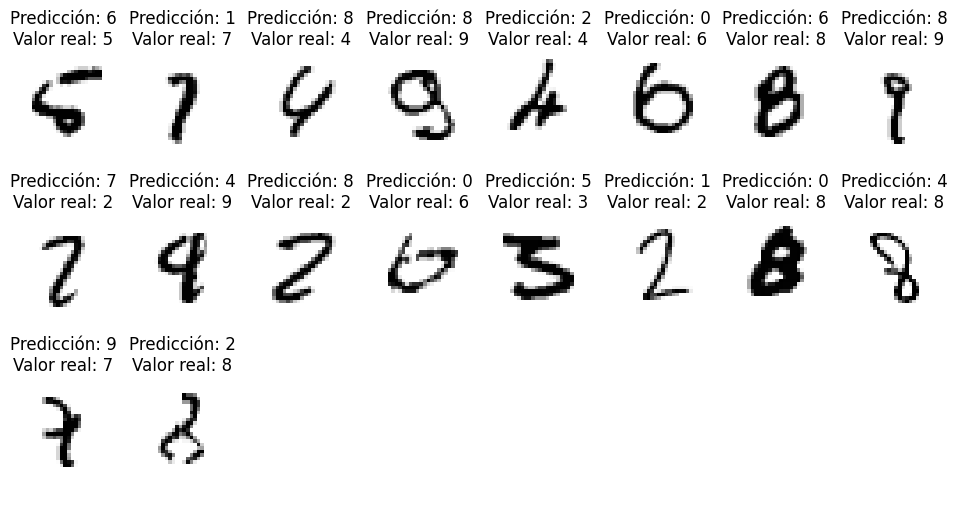

In [63]:
n_images = 18
n_columns = 8

n_rows = int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))

# Veamos algunos ejemplos de los datos en los que se equivocó
for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ierror][i], interpolation='None', cmap='binary')
    ax.set_title('Predicción: {}\nValor real: {}'.format(y_test[ierror][i], t_test[ierror][i]))

for ax in axs.flatten():
    ax.axis('off')

Bien, esto parece razonable, ¿verdad? Miren esos números. Algunos son realmente difíciles....

Veamos la distribución de probabilidades. Usa la probabilidad de la clase que fue elegida por la red, tanto en el caso de los errores como de los que no lo fueron.

In [62]:
pred_proba_all = np.max(model.predict(X_test), axis=1)

pred_proba = np.max(model.predict(X_test[~ierror]), axis=1)
pred_proba_err = np.max(model.predict(X_test[ierror]), axis=1)

10/10 [==============================] - 0s 2ms/step


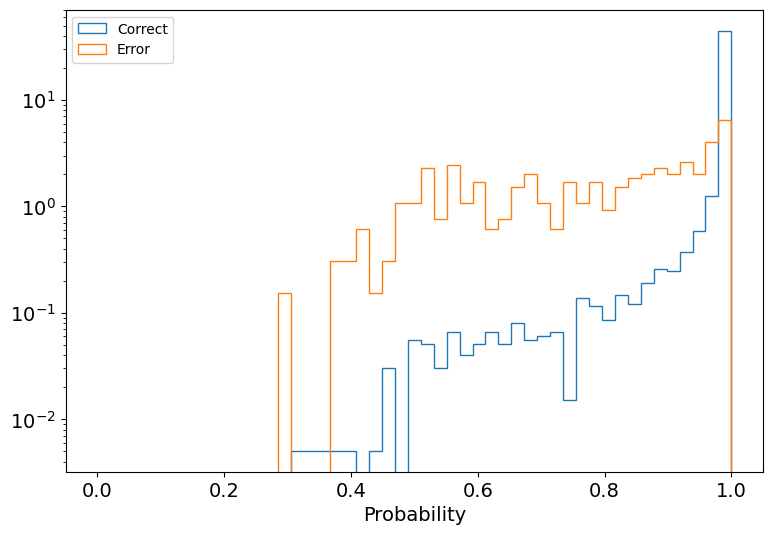

In [64]:
# Veamos la distribución
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1, 50)
plt.hist(pred_proba, bins=bins, histtype='step', label='Correct', density=True, log=True)
plt.hist(pred_proba_err, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

Esto es bueno. La red parece estar menos segura cuando comete errores. Esto significa que podríamos ajustar un poco el umbral de decisión para mejorar el rendimiento.

Pero parece estar bastante segura de algunos casos en los que se equivoca. Vamos a verlos.

In [65]:
ii = (pred_proba_all > 0.95) * (y_test - t_test != 0)

print('Hay {} imágenes erróneamente clasificadas y con prbabilidad por encima del 95%'.format(sum(ii)))

Hay 75 imágenes erróneamente clasificadas y con prbabilidad por encima del 95%


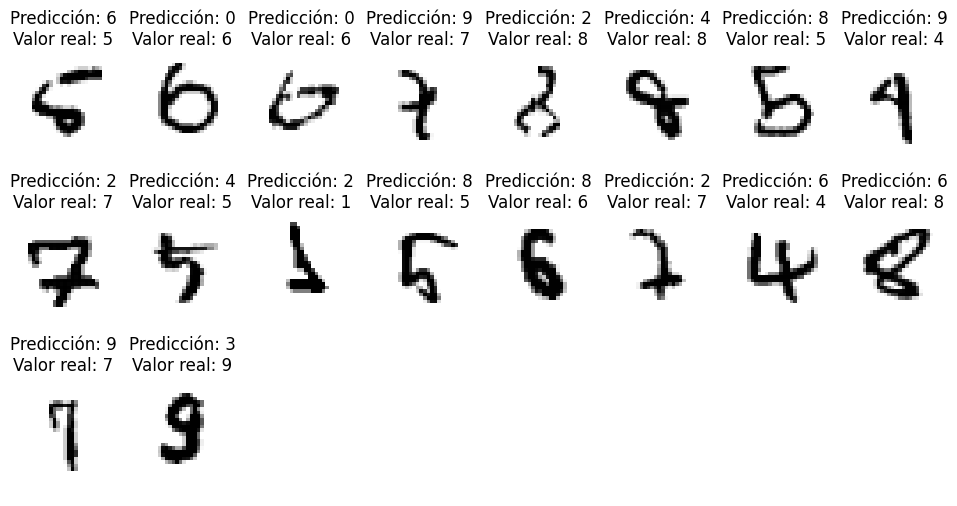

In [68]:
n_images = 18
n_columns = 8

n_rows = int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))
# Veamos algunos ejemplos de los datos en los que se equivocó

for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ii][i], interpolation='None', cmap='binary')
    ax.set_title('Predicción: {}\nValor real: {}'.format(y_test[ii][i],
                                                    t_test[ii][i]))

for ax in axs.flatten():
    ax.axis('off')

#### Cómo aprende la red.

Intentemos mirar dentro de la red para entender si entendió algo sobre cómo son los números o no. Hay muchos parámetros, pero tenemos la esperanza de que al menos la primera capa sea algo razonable, como un detector de bordes. Veamos.

Leamos los pesos y el sesgo de la primera capa oculta y veamos las formas.

In [70]:
# Tengan en cuenta que aquí la capa relevante es la capa[1], ya que la capa[0] es una capa de aplanamiento.
W, b = model.layers[1].get_weights()
print(W.shape, b.shape)

(784, 32) (32,)


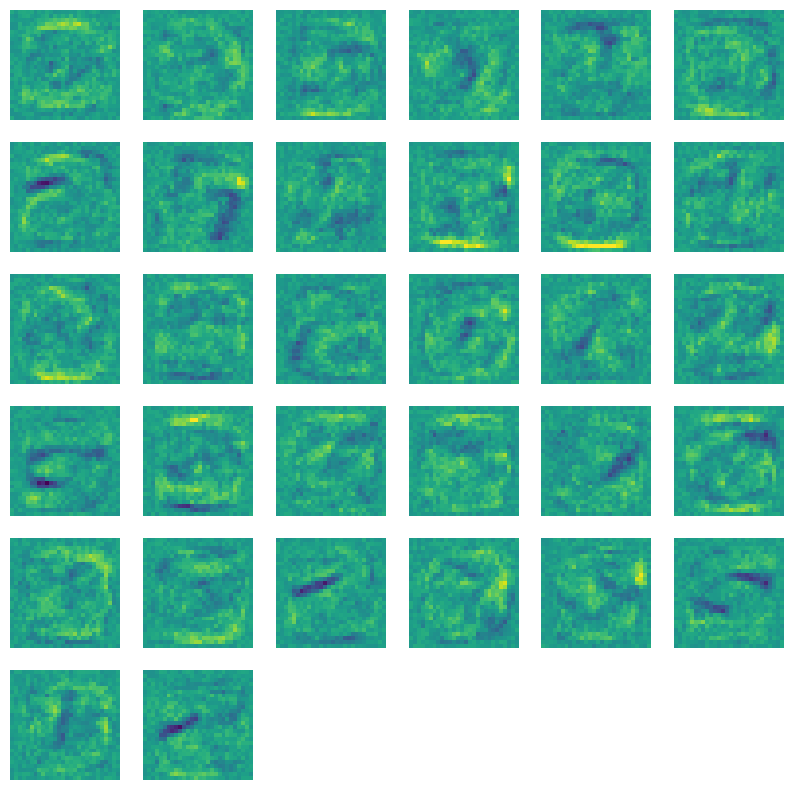

In [71]:
WW = W.reshape([28,28,32])

# Encontrar límites relevantes para los valores de los píxeles
Wmin = WW[3:-3, 3:-3].min()
Wmax = WW[3:-3, 3:-3].max()

fig = plt.figure(figsize=(10,10))
for i in range(WW.shape[-1]):
    ax = fig.add_subplot(6, 6, i+1)
    #  ax.imshow(WW[2:-2, 2:-2, i], interpolation='None')
    # Fixed limits in Z axis

    ax.imshow(WW[:, :, i], interpolation='None', vmin=Wmin, vmax=Wmax)
    ax.axis('off')

Los pesos de la primera capa no parecen en absoluto detectores de fronteras, ni nada parecido.

Parece que la red encuentra una forma mucho más extraña de generalizar de lo que haríamos nosotros. Veremos que las CNN hacen algo mucho más cercano a lo que uno esperaría.

**¿Tiene esto sentido?**

* Nunca proporcionamos una idea de la vecindad entre las características. ¿Cómo podría saberlo la red?
* ¿Cómo podemos generar una red neuronal que reconozca las imágenes de forma más parecida a como lo hacen los humanos?